In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets.Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap_path = path_to_module + 'Datasets/'
hashmap = get_hashmap(hashmap_path)
dataset_name = 'emnist_balanced_digits'
#update_inner_hashmap([dataset_name,'batch_size'],1024,hashmap_path)
dataset_properties = hashmap[dataset_name]
print(dataset_properties)

dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

{'batch_size': 1024, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}
Data_Shape is: 1
Batches Number is: 28


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 10
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 5e-4
sil_lambda = 0.02
entr_lambda = 0.02

kmeans_initialization = True
pretrain = True
is_MLP_AE = False

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()

autoencoder = autoencoder.to(device)

In [8]:
autoencoder

CD_Autoencoder(
  (encoder_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=10, bias=True)
    (11): Tanh()
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): RBF()
  )
  (decoder_model): Sequential(
    (0): Linear(in_feature

### Pretrain Autoencoder

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + '/Weigths/autoencoder_weights.pth'
    autoencoder.load_state_dict(torch.load(model_save_path))

Epoch: 0, Loss: 20.005201
Epoch: 1, Loss: 14.699464
Epoch: 2, Loss: 12.889613
Epoch: 3, Loss: 11.576996
Epoch: 4, Loss: 10.493243
Epoch: 5, Loss: 9.516870
Epoch: 6, Loss: 8.652751
Epoch: 7, Loss: 7.860828
Epoch: 8, Loss: 7.152526
Epoch: 9, Loss: 6.501049
Epoch: 10, Loss: 5.920237
Epoch: 11, Loss: 5.371627
Epoch: 12, Loss: 4.869942
Epoch: 13, Loss: 4.412416
Epoch: 14, Loss: 3.995698
Epoch: 15, Loss: 3.613041
Epoch: 16, Loss: 3.269241
Epoch: 17, Loss: 2.943242
Epoch: 18, Loss: 2.648992
Epoch: 19, Loss: 2.388506
Epoch: 20, Loss: 2.154216
Epoch: 21, Loss: 1.939403
Epoch: 22, Loss: 1.749628
Epoch: 23, Loss: 1.570955
Epoch: 24, Loss: 1.421213
Epoch: 25, Loss: 1.282847
Epoch: 26, Loss: 1.157847
Epoch: 27, Loss: 1.046460
Epoch: 28, Loss: 0.947587
Epoch: 29, Loss: 0.869194
Epoch: 30, Loss: 0.793525
Epoch: 31, Loss: 0.728202
Epoch: 32, Loss: 0.665648
Epoch: 33, Loss: 0.619476
Epoch: 34, Loss: 0.577860
Epoch: 35, Loss: 0.543685
Epoch: 36, Loss: 0.508952
Epoch: 37, Loss: 0.482117
Epoch: 38, Loss: 

### Initialize the clustering layer using k-means

In [10]:
n_inits = 100
if kmeans_initialization: autoencoder.kmeans_initialization(n_inits)

ACC: 0.67 PUR: 0.72 NMI: 0.68 ARI: 0.56


### Train Autoencoder

In [12]:
autoencoder.set_training_variables(n_epochs=10, lr=5e-4, sil_lambda=0.02, entr_lambda=0.02)
latent_data, labels, clustering = autoencoder.train_autoencoder()
cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()

Ep: 0 Rec L: 0.3554 Cl L: 0.5899 Entropy: 1.7588 SSil: -1.4934 SIL: 0.0000 ACC: 0.66 PUR: 0.70 NMI: 0.66 ARI: 0.53
Ep: 1 Rec L: 0.3058 Cl L: 0.5927 Entropy: 1.7369 SSil: -1.6359 SIL: 0.0000 ACC: 0.67 PUR: 0.71 NMI: 0.66 ARI: 0.54
Ep: 2 Rec L: 0.3120 Cl L: 0.5955 Entropy: 1.7258 SSil: -1.7727 SIL: 0.0000 ACC: 0.67 PUR: 0.71 NMI: 0.66 ARI: 0.54
Ep: 3 Rec L: 0.3123 Cl L: 0.5975 Entropy: 1.7086 SSil: -1.8746 SIL: 0.0000 ACC: 0.67 PUR: 0.71 NMI: 0.67 ARI: 0.54
Ep: 4 Rec L: 0.3187 Cl L: 0.5999 Entropy: 1.6838 SSil: -1.9969 SIL: 0.0000 ACC: 0.68 PUR: 0.72 NMI: 0.67 ARI: 0.55
Ep: 5 Rec L: 0.3349 Cl L: 0.6024 Entropy: 1.6518 SSil: -2.1223 SIL: 0.0000 ACC: 0.68 PUR: 0.72 NMI: 0.68 ARI: 0.56
Ep: 6 Rec L: 0.3496 Cl L: 0.6056 Entropy: 1.6052 SSil: -2.2819 SIL: 0.0000 ACC: 0.68 PUR: 0.73 NMI: 0.69 ARI: 0.57
Ep: 7 Rec L: 0.3722 Cl L: 0.6054 Entropy: 1.5484 SSil: -2.2716 SIL: 0.0000 ACC: 0.69 PUR: 0.73 NMI: 0.70 ARI: 0.58
Ep: 8 Rec L: 0.3956 Cl L: 0.6046 Entropy: 1.4858 SSil: -2.2317 SIL: 0.0000 ACC: 

In [ ]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [ ]:
visualization.plot(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [ ]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

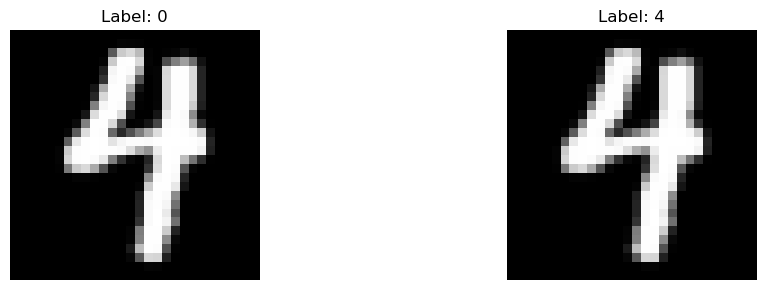

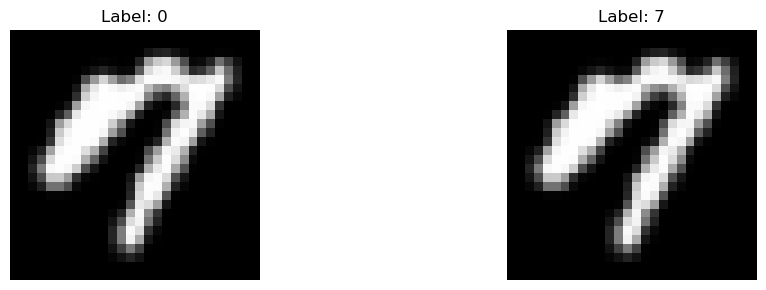

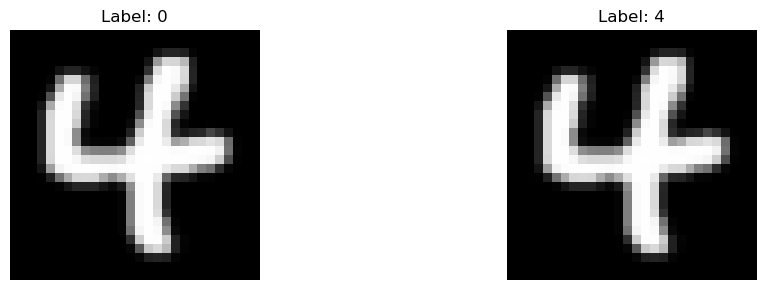

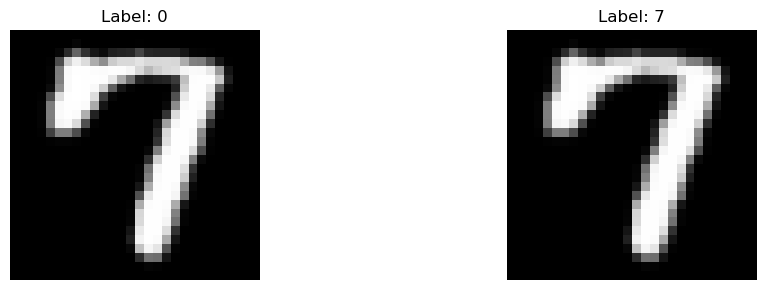

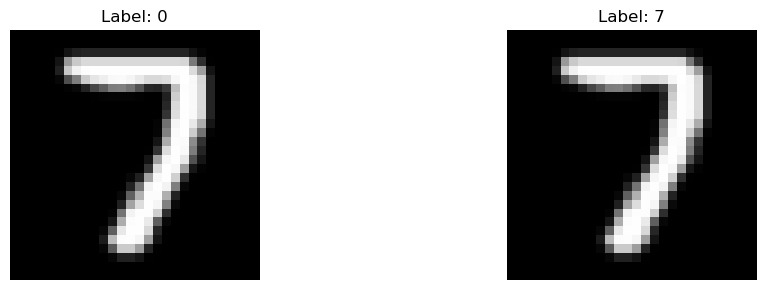

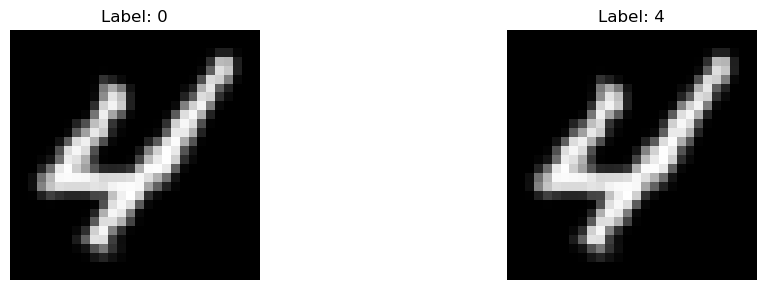

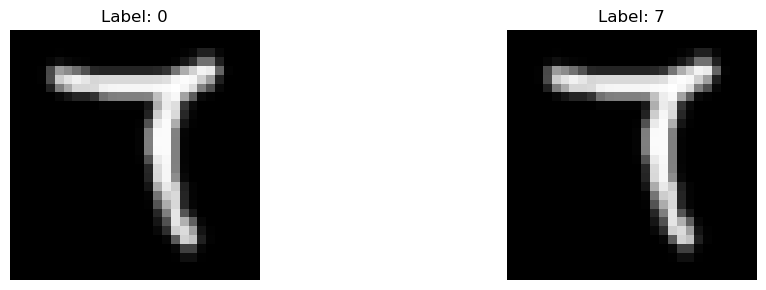

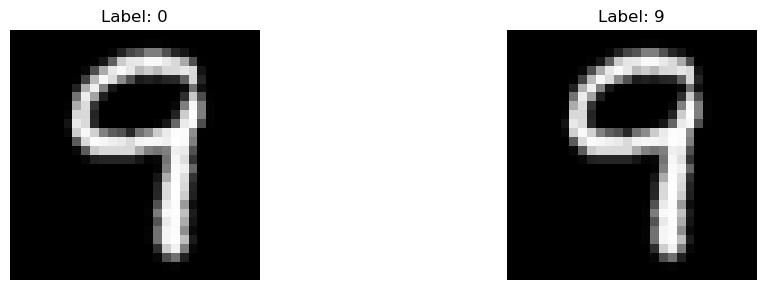

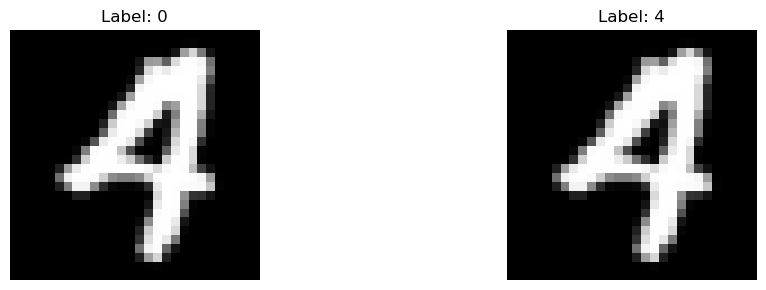

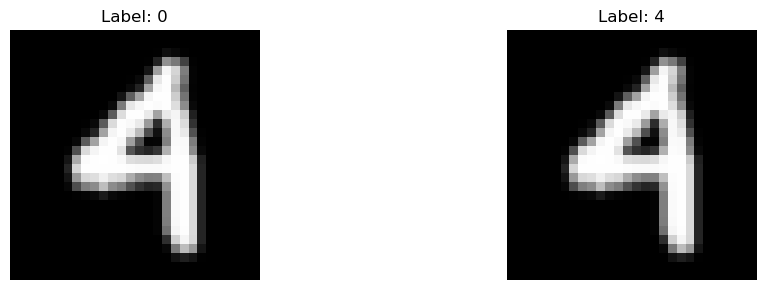

In [23]:
similarity_data, similarity, similarity_real_labels = autoencoder.get_similarity_data()
similarity_labels = autoencoder.torch_to_numpy(torch.tensor(similarity))
valid_indices = np.where(similarity_labels == 0)[0]
for index in valid_indices[:10]:    
    visualization.plot_images([similarity_data[index], similarity_data[index]], [similarity_labels[index], similarity_real_labels[index]])

In [31]:
valid_indices = np.where(similarity_labels == 0)[0]
for i in valid_indices:
    print(similarity[i])
    print(similarity[i][similarity_labels[i]])


[7.6005995e-01 2.7787603e-06 1.5724542e-03 3.1160092e-05 1.0117533e-05
 7.5057087e-06 3.2856251e-04 1.0087733e-05 1.5413990e-04 7.7461445e-06]
0.76005995
[3.9407808e-02 1.0133330e-07 1.7000963e-03 3.2524198e-08 2.3522252e-06
 3.6162046e-08 2.0475280e-05 1.5122345e-06 4.7277595e-06 1.2969128e-06]
0.03940781
[4.2324010e-03 1.2531091e-08 7.1128903e-05 7.8071542e-11 1.2699296e-09
 8.4079343e-10 2.2873890e-07 3.4049746e-10 1.9551021e-06 1.2007850e-08]
0.004232401
[1.2779693e-01 4.8941897e-06 7.3340914e-04 6.7055130e-06 1.7579197e-05
 2.6949560e-09 2.0351310e-05 2.3125692e-07 5.0626586e-06 7.1919790e-09]
0.12779693
[8.7449094e-03 1.2790547e-03 6.9061811e-03 9.2926394e-04 7.4155456e-03
 9.8018361e-08 1.2605153e-03 5.4169118e-07 2.4051631e-03 7.5617243e-07]
0.008744909
[8.9108752e-04 3.3236034e-08 7.2747312e-04 3.9407946e-10 4.3656604e-07
 4.0155337e-09 1.5543294e-05 1.5620616e-08 4.0439400e-06 1.8919046e-07]
0.0008910875
[1.0354252e-01 1.9334508e-04 1.8841920e-03 1.0824845e-03 6.2919251e-05
 

[8.6087292e-01 4.2119376e-05 1.2098933e-02 1.9429220e-04 6.0784852e-05
 9.0870981e-06 2.1230795e-03 2.5541311e-05 3.5752216e-04 1.8602868e-05]
0.8608729
[7.2335452e-01 6.3366092e-06 4.4219434e-04 9.0308946e-05 9.1813072e-06
 6.4220367e-06 2.0751586e-04 1.1685259e-05 5.3580428e-05 1.1260554e-06]
0.7233545
[2.5430477e-01 8.7812191e-07 1.4264770e-05 1.7171934e-04 3.3301808e-06
 1.4145617e-06 2.0387539e-05 2.9851821e-05 2.2590366e-06 5.1077865e-07]
0.25430477
[1.08998185e-02 8.97770913e-10 5.65561368e-06 7.13901549e-10
 9.66999210e-08 5.99228756e-09 2.18657533e-07 3.38787430e-07
 5.95411258e-08 8.32654656e-09]
0.0108998185
[6.2091738e-01 9.4618874e-05 4.9181759e-02 1.5302982e-04 9.2325805e-05
 6.5549298e-06 2.9433582e-03 4.0873852e-06 2.8855200e-03 2.5646290e-05]
0.6209174
[2.0213390e-02 3.4405858e-07 1.7997310e-07 2.2211339e-05 3.7049747e-05
 3.6336346e-06 5.5108649e-07 1.3203279e-03 1.5288765e-07 1.3940918e-07]
0.02021339
[2.1672403e-03 4.6399138e-09 4.4342403e-07 1.0149215e-10 2.0958266